# Ball is Life

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from src.utils.gan_trainer import ModelTrainer
from src.utils.data_utils import NumpyGIFs
from src.utils.gan_trainer import ModelTrainer
from src.utils.initializer import Initializer

from src.models.latent_lstm_vaegan import LatentLSTM
from src.models.vaegan import VAEGAN_Gen, VAEGAN_Disc, Initializer

from src.utils.vis_utils import *

import numpy as np
import os

%load_ext autoreload
%autoreload 2

# TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'latent-lstm-gan')

In [2]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [3]:
IMAGE_SZ = (64, 64)
NUM_WORKERS = 4
IMG_BATCH_SZ = 128
GIF_BATCH_SZ = 64
TRANSFORMS = transforms.Compose([transforms.ToTensor()])
DISP_LIM = 8

In [4]:
MAX_FRAMES = 10

DATASET_ROOT = os.path.join(os.getcwd(), 'src', 'datasets', 'BBall', '2')
train_set = NumpyGIFs(f'{DATASET_ROOT}/train.npy', temporality=True, transform=TRANSFORMS)
val_set = NumpyGIFs(f'{DATASET_ROOT}/val.npy', temporality=True, transform=TRANSFORMS)

Loading /home/mtroute/project/src/datasets/BBall/2/train.npy...
Loaded 80000 examples.
Loading /home/mtroute/project/src/datasets/BBall/2/val.npy...
Loaded 10000 examples.


In [6]:
BATCH_SZ = 32
NUM_WORKERS = 4

train_loader = DataLoader(train_set, batch_size=BATCH_SZ, 
                                 shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

val_loader = DataLoader(val_set, batch_size=BATCH_SZ, 
                               shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

In [ ]:
%matplotlib inline

gif = iter(train_loader).next()[0]
img_show(torchvision.utils.make_grid(gif))

In [ ]:
import matplotlib.pyplot as plt

def gif_show(gif):
    npimg = gif.numpy()
    out = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(20,40))
    plt.imshow(out)

def sample(model, seed_frame, gif_length=10):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    model.eval()
    ret = [seed_frame]
    for i in range(gif_length - 1):
        y, curr_h = model(curr_x, curr_h)
        curr_x = y
        ret.append(y.to(device = torch.device('cpu')))
    return torch.stack(ret).transpose(0, 1)
    
def img_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[0]
    print (x.shape)
    x = torch.tensor(x)
    x = x.to(device=device, dtype=dtype)
    y, mu, logvar = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    print (imgs.shape)
    gif_show(torchvision.utils.make_grid(imgs))
    
def gif_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[:, 0, :, :, :]
    x = x.to(device=device, dtype=dtype)
    y, mu, logvar = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    gif_show(torchvision.utils.make_grid(imgs))

In [ ]:
LATENT_SIZE = 20
VAEGAN_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'vaegan-bball', '2')

In [ ]:
def train_vaegan(gen_model, disc_model, g_optimizer, d_optimizer, x):
    
    criterion = nn.BCEWithLogitsLoss(size_average=True)
    gan_reg = 1e-4 
    kl_reg = 1e-8
    disc_err_fake_reg = 1

    gen_model.train()
    disc_model.train()            

    d_optimizer.zero_grad()

    x = x[:, 0]
    x = x.to(device=device, dtype=dtype)

    recon_x, mu, logvar = gen_model(x)

    rec_noise = gen_model.decoder(torch.randn(x.shape[0], LATENT_SIZE, device=device))  # TODO: magic numbers

    logits_real = disc_model(x).squeeze()
    logits_fake = disc_model(recon_x).squeeze()
    logits_err = disc_model(rec_noise).squeeze()


    all_ones = torch.ones(logits_real.shape[0], device=device)
    all_zeros = torch.zeros(logits_real.shape[0], device=device)

    # train discriminator
    disc_err_real = criterion(logits_real, all_ones)
    disc_err_fake = disc_err_fake_reg * criterion(logits_fake, all_zeros)
    disc_err_noise = criterion(logits_err, all_zeros)     # random noise

    disc_loss = disc_err_real + disc_err_fake

    disc_loss.backward()
    d_optimizer.step()

    g_optimizer.zero_grad()
    recon_x, mu, logvar = gen_model(x)

    gen_logits_fake = disc_model(recon_x)
    gen_logits_fake = gen_logits_fake.squeeze()

    gen_loss_gan = gan_reg * criterion(gen_logits_fake, all_ones)
    mse_loss = nn.MSELoss(size_average=True)
    MSE = mse_loss(recon_x, x)            
    KLD = kl_reg * (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    gen_loss = MSE + KLD + gen_loss_gan

    gen_loss.backward()
    g_optimizer.step()
    
    gen_loss_str = f'recr: {MSE:.6f}, gan: {gen_loss_gan:.6f}'
    disc_loss_str = f'real: {disc_err_real:.6f}, fake: {disc_err_fake:.6f}'    
    
    return gen_loss, disc_loss, gen_loss_str, disc_loss_str

In [ ]:
NUM_CHANNELS = 1
INPUT_SIZE = 64 * 64 * NUM_CHANNELS

gen_vaegan = VAEGAN_Gen(latent_size=LATENT_SIZE, device=device, num_channels=NUM_CHANNELS)
disc_vaegan = VAEGAN_Disc(latent_size=LATENT_SIZE, device=device, num_channels=NUM_CHANNELS)

Initializer.initialize(model=gen_vaegan, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
Initializer.initialize(model=disc_vaegan, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))

gen_vaegan_optimizer = optim.Adam(gen_vaegan.parameters(), lr=5e-4)
disc_vaegan_optimizer = optim.Adam(disc_vaegan.parameters(), lr=5e-4)

In [ ]:
try:
    print('Starting training...')
    trainer = ModelTrainer(gen_vaegan, disc_vaegan, gen_vaegan_optimizer, disc_vaegan_optimizer, train_vaegan, VAEGAN_MODEL_PATH, tags=["vaegan", "bball"])
    trainer.train(train_loader, epochs=2, print_every=1000)
except KeyboardInterrupt:
    print("Interrupting...")
    trainer.save_data(force_save=True)
    
trainer.save_data(force_save=True)
print ("Done.")

In [ ]:
img_test_autoenc(gen_vaegan, train_loader)

In [ ]:
img_test_autoenc(gen_vaegan, val_loader)

In [ ]:
def gen_image(model):
    z = torch.randn((16, LATENT_SIZE), device=device)
    y = model.decoder(z)
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    img_show(torchvision.utils.make_grid(y))
    
gen_image(gen_vaegan)

In [ ]:
BATCH_IDX = 15
BATCH_LIM = 1

def vary_latent(init_z, step, length, dim, model, orig_img):
    orig_img = orig_img.to(torch.device('cpu')).detach()

    ret = []
    curr_z = init_z.clone()
    curr_z = curr_z.to(device=device)
    
    model.eval()
    for batch in range(BATCH_LIM):
        curr_z = init_z.clone()
        ret.append(orig_img[batch]) 
        for i in range(length):
            curr_z[:, dim] += step
            y = model.decoder(curr_z)
            y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
            ret.append(y[batch])
    
    gif_show(torchvision.utils.make_grid(torch.stack(ret)))
        
        
    

def get_latent_z(model, x):
    enc_y = model.encoder(x)
    mu, logvar = model.fc_mu(enc_y), model.fc_logvar(enc_y)
    return model.sample_latent(mu, logvar)


def sample_forward(model, z):
    return model.decoder(z)


def test_varying(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()    
    x = x[0]
    x = x.to(device=device, dtype=dtype)

    z = get_latent_z(model, x)
    vary_latent(z, 4.0, 7, 2, model, x)
    
test_varying(gen_vaegan, train_loader)

In [15]:
DISP_LIM = 16

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


def make_gif(model, seed_frame, gif_length=20):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    ret = [seed_frame]
    
    for i in range(gif_length - 1): 
        y, curr_h = model(curr_x, curr_h)
        curr_x = y
        ret.append(y.to(device = torch.device('cpu')))
    
    return torch.stack(ret).transpose(0, 1).squeeze()

def test_lstm_eval(model, loader, counter):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    
    seeds = x[:, 0, :, :, :]
    seeds = seeds.unsqueeze(1)
    gif = make_gif(model, seeds)
    
    orig_gifs = torch.cat(tuple(x))[:DISP_LIM]
    out_gifs = torch.cat(tuple(gif))[:DISP_LIM]
    
#     orig_gifs = x[0]
#     out_gifs = gif[0]
    out_gifs = out_gifs.clamp(0, 1).unsqueeze(1)    
    
#     save_as_gif (f"./output/{counter}_real.gif", orig_gifs.detach())
#     save_as_gif (f"./output/{counter}_fake.gif", out_gifs.detach())
    
    img_show(torchvision.utils.make_grid(orig_gifs))
    img_show(torchvision.utils.make_grid(out_gifs.detach()))

def test_lstm_train(model, loader):
    model.train()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x.to(device=device)
    
    orig_gifs = torch.cat(tuple(x))[:DISP_LIM]
    orig_gifs = orig_gifs.cpu().detach()
    
    out_gifs, hidden_out = model(x, model.init_hidden(BATCH_SZ))
    out_gifs = out_gifs[0]
    out_gifs = out_gifs.clamp(0, 1)
    out_gifs = out_gifs.cpu().detach()[:DISP_LIM]  
    
    img_show(torchvision.utils.make_grid(orig_gifs))
    img_show(torchvision.utils.make_grid(out_gifs)) 

In [ ]:
def train_lstm(gen_model, disc_model, gen_optimizer, disc_optimizer, x):
    
    N, T, C, H, W = x.shape
    
    criterion = nn.BCEWithLogitsLoss(size_average=True)
    gan_reg = 1e-4
    kl_reg = 1e-8
    disc_err_fake_reg = 1
    
    h0 = gen_model.init_hidden(BATCH_SZ)
    
    gen_model.train()
    disc_model.train()            

    disc_optimizer.zero_grad()

    x = x.to(device=device, dtype=dtype)
    
    next_frames, _ = gen_model(x, h0)
    
    orig_x = x[:, 1:, :]
    recon_x = next_frames[:, :-1, :]
    
    logits_real = disc_model(orig_x.contiguous().view(-1, C, H, W)).squeeze()
    logits_fake = disc_model(recon_x.contiguous().view(-1, C, H, W)).squeeze()
    
    all_ones = torch.ones(logits_real.shape[0], device=device)
    all_zeros = torch.zeros(logits_real.shape[0], device=device)
    
    disc_err_real = criterion(logits_real, all_ones)
    disc_err_fake = disc_err_fake_reg * criterion(logits_fake, all_zeros)    
    
    disc_loss = disc_err_real + disc_err_fake    
    
    disc_loss.backward()
    disc_optimizer.step()    
    
    # generator loss
    gen_optimizer.zero_grad()    
    
    next_frames, _ = gen_model(x, h0)
    recon_x = next_frames[:, :-1, :]
    
    gen_logits_fake = disc_model(recon_x.contiguous().view(-1, C, H, W)).squeeze()
    gen_loss_gan = gan_reg * criterion(gen_logits_fake, all_ones)    
    
    MSE = F.mse_loss(orig_x, recon_x, size_average=True)
    
    gen_loss = MSE + gen_loss_gan
    
    gen_loss.backward()
    gen_optimizer.step()
    
    gen_loss_str = f'recr: {MSE:.6f}, gan: {gen_loss_gan:.6f}'
    disc_loss_str = f'real: {disc_err_real:.6f}, fake: {disc_err_fake:.6f}'    
    
    return gen_loss, disc_loss, gen_loss_str, disc_loss_str

In [7]:
LATENT_SIZE = 20
NUM_CHANNELS = 1
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS   
HIDDEN_SIZE = INPUT_SIZE
OUTPUT_SIZE = INPUT_SIZE
LSTMGAN_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'lstmgan-bball')

gen_lstm = LatentLSTM(latent_size=LATENT_SIZE, hidden_size=200, device=device, num_channels=NUM_CHANNELS, num_rnn_layers=1)
disc_lstm = VAEGAN_Disc(latent_size=LATENT_SIZE, device=device, num_channels=NUM_CHANNELS)

Initializer.initialize(model=gen_lstm, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
Initializer.initialize(model=disc_lstm, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))

gen_lstm_optimizer = optim.Adam(gen_lstm.parameters(), lr=1e-3)
disc_lstm_optimizer = optim.Adam(disc_lstm.parameters(), lr=1e-3)

# trainer = ModelTrainer(gen_lstm, disc_lstm, gen_lstm_optimizer, disc_lstm_optimizer, train_lstm, LSTMGAN_MODEL_PATH, tags=["lstm", "lstm-gan", "bball"])

In [ ]:
# trainer.train(train_loader, verbose=True, epochs=1, print_every=500)
# trainer.save_data(force_save=True)

In [10]:
# trainer.save_data(force_save=True)
ModelTrainer.load_model(LSTMGAN_MODEL_PATH + '/experiment_7/checkpoints', gen_lstm, disc_lstm)

In [11]:
counter = 7

Train set performance, eval mode:


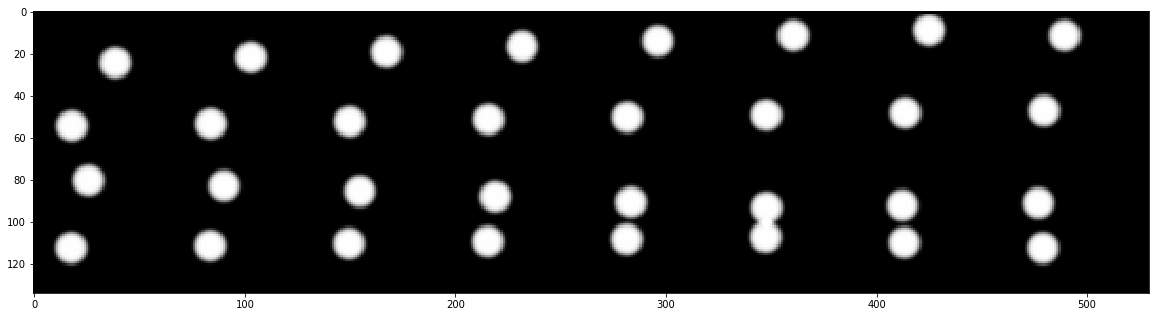

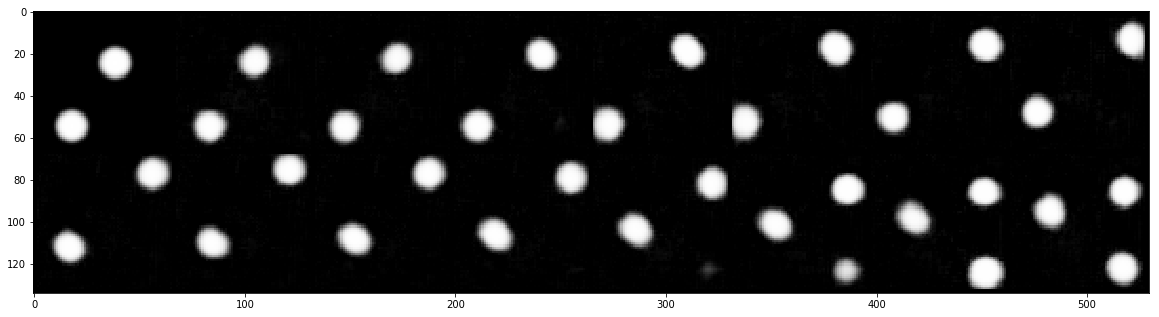

In [32]:
print ('Train set performance, eval mode:')

test_lstm_eval(gen_lstm, train_loader, counter)
counter += 1

In [ ]:
print ('Train set performance, train mode:')
test_lstm_train(gen_lstm, train_loader)